# CUSTOMER CHURN
Data downloaded from [IBM Accelerator Catalog](https://community.ibm.com/accelerators/catalog/content/Telco-customer-churn)

December 2021
___

## DESCRIPTION
The task of churn is to predict behavior to retain customers.To do this, a survival analysis was carried out, which is used for modeling and analyzing survival rate (likely to survive) and hazard rate (likely to die). Machine learning models were also applied to solve the classification problem.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from category_encoders.cat_boost import CatBoostEncoder
from scipy.stats import mannwhitneyu

from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import median_survival_times

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, \
                            f1_score, plot_confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.model_selection import LearningCurve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
import pickle

from IPython.display import display 

# keeping experiments reproducible
RANDOM_SEED = 42 
# settings to display all columns
pd.set_option('display.max_columns', None)
# setting the color palette
sns.set_palette(sns.color_palette('Set2'))

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
df = pd.read_excel('data/Telco_customer_churn.xlsx')
# remove spaces from column names
df.columns = [x.replace(' ', '') for x in df.columns.to_list()]

# creating a copy of the dataset
df_copy = df.copy()

df.head()

CustomerID  Count        Country       State         City  ZipCode  \
0  3668-QPYBK      1  United States  California  Los Angeles    90003   
1  9237-HQITU      1  United States  California  Los Angeles    90005   
2  9305-CDSKC      1  United States  California  Los Angeles    90006   
3  7892-POOKP      1  United States  California  Los Angeles    90010   
4  0280-XJGEX      1  United States  California  Los Angeles    90015   

                  LatLong   Latitude   Longitude  Gender SeniorCitizen  \
0  33.964131, -118.272783  33.964131 -118.272783    Male            No   
1   34.059281, -118.30742  34.059281 -118.307420  Female            No   
2  34.048013, -118.293953  34.048013 -118.293953  Female            No   
3  34.062125, -118.315709  34.062125 -118.315709  Female            No   
4  34.039224, -118.266293  34.039224 -118.266293    Male            No   

  Partner Dependents  TenureMonths PhoneService MultipleLines InternetService  \
0      No         No             2          Yes            No             DSL   
1      No        Yes             2          Yes            No     Fiber optic   
2      No        Yes             8          Yes           Yes     Fiber optic   
3     Yes        Yes            28          Yes           Yes     Fiber optic   
4      No        Yes            49          Yes           Yes     Fiber optic   

  OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0            Yes          Yes               No          No          No   
1             No           No               No          No          No   
2             No           No              Yes          No         Yes   
3             No           No              Yes         Yes         Yes   
4             No          Yes              Yes          No         Yes   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0              No  Month-to-month              Yes               Mailed check   
1              No  Month-to-month              Yes           Electronic check   
2             Yes  Month-to-month              Yes           Electronic check   
3             Yes  Month-to-month              Yes           Electronic check   
4             Yes  Month-to-month              Yes  Bank transfer (automatic)   

   MonthlyCharges TotalCharges ChurnLabel  ChurnValue  ChurnScore  CLTV  \
0           53.85       108.15        Yes           1          86  3239   
1           70.70       151.65        Yes           1          67  2701   
2           99.65        820.5        Yes           1          86  5372   
3          104.80      3046.05        Yes           1          84  5003   
4          103.70       5036.3        Yes           1          89  5340   

                     ChurnReason  
0   Competitor made better offer  
1                          Moved  
2                          Moved  
3                          Moved  
4  Competitor had better devices

## Dataset information

### Features


**Demographics**

- CustomerID: A unique ID that identifies each customer.

- Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

- Gender: The customer’s gender: Male, Female

- Partner: Indicates if the customer is in a relationship: Yes, No

- SeniorCitizen: Indicates if the customer is 65 or older: Yes, No

- Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.


**Location**

- Country: The country of the customer’s primary residence.

- State: The state of the customer’s primary residence.

- City: The city of the customer’s primary residence.

- ZipCode: The zip code of the customer’s primary residence.

- LatLong: The combined latitude and longitude of the customer’s primary residence.

- Latitude: The latitude of the customer’s primary residence.

- Longitude: The longitude of the customer’s primary residence.

  

**Services**

- TenureMonths: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

- PhoneService: Indicates if the customer subscribes to home phone service with the company: Yes, No

- MultipleLines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

- InternetService: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

- OnlineSecurity: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

- OnlineBackup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

- DeviceProtection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

- TechSupport: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

- StreamingTV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

- StreamingMovies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

- Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

- PaperlessBilling: Indicates if the customer has chosen paperless billing: Yes, No

- PaymentMethod: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

- MonthlyCharge: Indicates the customer’s current total monthly charge for all their services from the company.

- TotalCharges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.


**Status**

- ChurnLabel: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

- ChurnValue: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

- ChurnScore: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

- CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

- ChurnReason: A customer’s specific reason for leaving the company. Directly related to Churn Category.



In [3]:
df.shape

(7043, 33)

In [4]:
# handling demographic features

df['Count'].nunique()
# deleting a constant column
df.drop(['Count'], axis=1, inplace=True)

# check for duplicates
print(f'Number of duplicates: {df.duplicated().sum()}')

Number of duplicates: 0


In [5]:
# target encoding using CatBoostEncoder
target = df[['ChurnValue']]
train = df['City']
  
cbe_encoder = CatBoostEncoder()
  
# fit encoder and transform the features
cbe_encoder.fit(train, target)
df['CityTargetEnc'] = cbe_encoder.transform(train)

In [6]:
# churn customers by city
df_city_churn = df.groupby('City')['CityTargetEnc'].mean().reset_index()

# engineering a new feature meaning successful, failed and dangerous cities in terms of churn customers
df_city_churn['ChurnStatus'] = pd.cut(df_city_churn['CityTargetEnc'], bins=[0, 0.33, 0.67, 1],
                         labels=['Success', 'Dangerous', 'Failure'])

# adding a column with churn statuses to the dataframe for visualization
df_city_churn = df.merge(df_city_churn[['ChurnStatus', 'City']], on='City', how='left')

# California state capital coordinates
coord_center = df_city_churn[df_city_churn['City']=='Sacramento'][['Latitude', 'Longitude']].sample(1)

# visualization of cities by churn status
fig = px.scatter_geo(df_city_churn, lat='Latitude', lon='Longitude', hover_name='City', scope='usa',
                     size_max=50, color='ChurnStatus', opacity=0.5,
                     center={'lat': coord_center['Latitude'].values[0],
                             'lon': coord_center['Longitude'].values[0]})

fig.update_layout(title = 'California cities by churn status', title_x=0.5, autosize=True)

fig.show()

In [7]:
# deleting all geographical data except the city
df.drop(['Country', 'State', 'City', 'ZipCode', 'LatLong', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [8]:
# important feature for data targeting is the ChurnValue
df.drop(['ChurnLabel', 'ChurnScore', 'ChurnReason'], axis=1, inplace=True)

In [9]:
# data type of each column
df.dtypes

CustomerID           object
Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
TenureMonths          int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
ChurnValue            int64
CLTV                  int64
CityTargetEnc       float64
dtype: object

In [10]:
# Type TotalCharges is object, check for unique values
df[~df['TotalCharges'].apply(lambda x: isinstance(x, (float, int)))]['TotalCharges'].values

array([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
      dtype=object)

In [11]:
# TotalCharges contains missing values in form of blankspaces
df['TotalCharges']=pd.to_numeric(df['TotalCharges'], errors='coerce') 

# checking the percentage of missing values
df.isnull().sum() / df.shape[0] * 100

CustomerID          0.000000
Gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
TenureMonths        0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.156183
ChurnValue          0.000000
CLTV                0.000000
CityTargetEnc       0.000000
dtype: float64

In [12]:
# explore the nature of missing values
df[df['TotalCharges'].isna()]

CustomerID  Gender SeniorCitizen Partner Dependents  TenureMonths  \
2234  4472-LVYGI  Female            No     Yes         No             0   
2438  3115-CZMZD    Male            No      No         No             0   
2568  5709-LVOEQ  Female            No     Yes         No             0   
2667  4367-NUYAO    Male            No     Yes        Yes             0   
2856  1371-DWPAZ  Female            No     Yes         No             0   
4331  7644-OMVMY    Male            No     Yes        Yes             0   
4687  3213-VVOLG    Male            No     Yes        Yes             0   
5104  2520-SGTTA  Female            No     Yes        Yes             0   
5719  2923-ARZLG    Male            No     Yes        Yes             0   
6772  4075-WKNIU  Female            No     Yes        Yes             0   
6840  2775-SEFEE    Male            No      No        Yes             0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  \
2234           No  No phone service             DSL                  Yes   
2438          Yes                No              No  No internet service   
2568          Yes                No             DSL                  Yes   
2667          Yes               Yes              No  No internet service   
2856           No  No phone service             DSL                  Yes   
4331          Yes                No              No  No internet service   
4687          Yes               Yes              No  No internet service   
5104          Yes                No              No  No internet service   
5719          Yes                No              No  No internet service   
6772          Yes               Yes             DSL                   No   
6840          Yes               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
2234                   No                  Yes                  Yes   
2438  No internet service  No internet service  No internet service   
2568                  Yes                  Yes                   No   
2667  No internet service  No internet service  No internet service   
2856                  Yes                  Yes                  Yes   
4331  No internet service  No internet service  No internet service   
4687  No internet service  No internet service  No internet service   
5104  No internet service  No internet service  No internet service   
5719  No internet service  No internet service  No internet service   
6772                  Yes                  Yes                  Yes   
6840                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
2234                  Yes                   No  Two year              Yes   
2438  No internet service  No internet service  Two year               No   
2568                  Yes                  Yes  Two year               No   
2667  No internet service  No internet service  Two year               No   
2856                  Yes                   No  Two year               No   
4331  No internet service  No internet service  Two year               No   
4687  No internet service  No internet service  Two year               No   
5104  No internet service  No internet service  Two year               No   
5719  No internet service  No internet service  One year              Yes   
6772                  Yes                   No  Two year               No   
6840                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  ChurnValue  \
2234  Bank transfer (automatic)           52.55           NaN           0   
2438               Mailed check           20.25           NaN           0   
2568               Mailed check           80.85           NaN           0   
2667               Mailed check           25.75           NaN           0   
2856    Credit card (automati

In [13]:
# checking the relationship of zero months and missing values in TotalCharges
(df[df['TotalCharges'].isna()].index == df[df['TenureMonths'] == 0].index).all()

True

In [14]:
# removing customers (11 customers) with missing values in TotalCharges, as they don't use the services even for one month
df = df.drop(df[df['TenureMonths'] == 0].index).reset_index(drop=True)

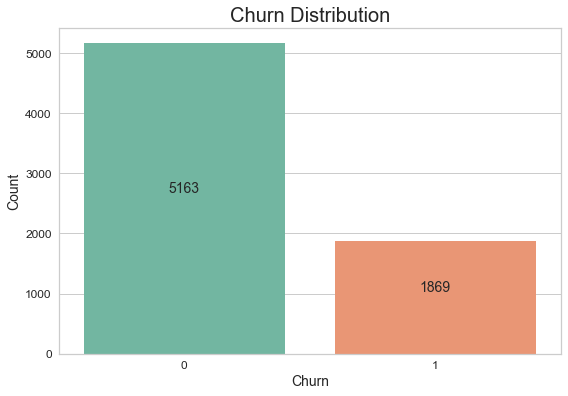

In [15]:
# explorary the target feature
ax = sns.countplot(df['ChurnValue'])

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()/2),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)
    
plt.title('Churn Distribution', fontsize=20)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Our target variable has imblanced data. 5163 customer didn't churn, 1869 customer churned 

In [16]:
# find binary and categorical columns 
df.describe(include=object).sort_values('unique', axis=1)

Gender SeniorCitizen Partner Dependents PhoneService PaperlessBilling  \
count    7032          7032    7032       7032         7032             7032   
unique      2             2       2          2            2                2   
top      Male            No      No         No          Yes              Yes   
freq     3549          5890    3639       5412         6352             4168   

       OnlineSecurity MultipleLines InternetService OnlineBackup  \
count            7032          7032            7032         7032   
unique              3             3               3            3   
top                No            No     Fiber optic           No   
freq             3497          3385            3096         3087   

       DeviceProtection TechSupport StreamingTV StreamingMovies  \
count              7032        7032        7032            7032   
unique                3           3           3               3   
top                  No          No          No              No   
freq               3094        3472        2809            2781   

              Contract     PaymentMethod  CustomerID  
count             7032              7032        7032  
unique               3                 4        7032  
top     Month-to-month  Electronic check  3668-QPYBK  
freq              3875              2365           1

In [17]:
# encode labels of binary variables
bin_cols = ['PaperlessBilling', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'ChurnValue']

label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

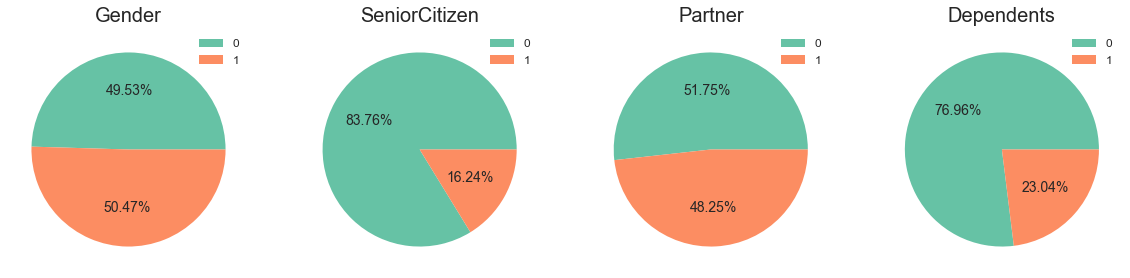

In [18]:
customers_info = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']
df_customers_info = df[customers_info].T.apply(lambda x: x.value_counts(), axis=1).T

fig, axes = plt.subplots(1, 4, figsize = (20, 15))

for ax, col in zip(axes, df_customers_info.columns):
    patches = ax.pie(df_customers_info[col].values, autopct='%.2f%%', textprops={'fontsize': 14})

    ax.set_title(col, fontsize=20)
    ax.legend(patches, labels=df_customers_info.index, fontsize=12)

The dataset contains mostly non-elderly clients of different genders. Half of them are couples, the other half are single. About 30% of clients have a dependents

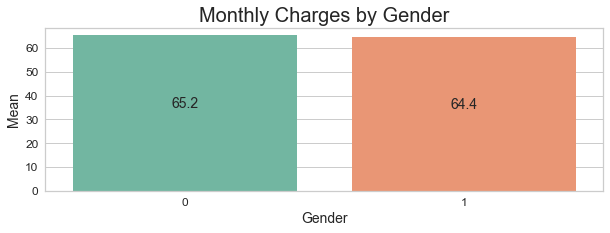

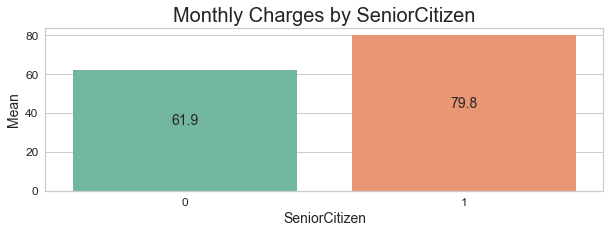

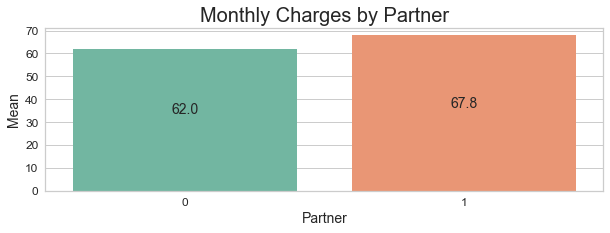

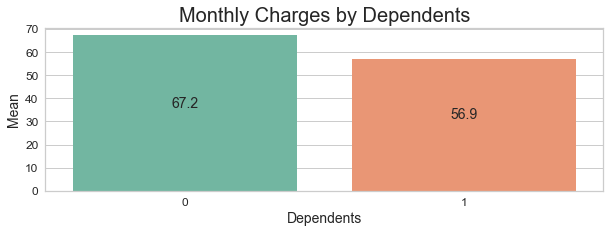

In [19]:
for col in customers_info:
    monthlycharges_by_col = df.groupby(col)['MonthlyCharges'].mean().rename('mean').reset_index()
    
    fig, axes = plt.subplots(figsize = (10, 3))
    
    ax = sns.barplot(x=col, y='mean', data=monthlycharges_by_col, ax=axes)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                    ha='center',  
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',  
                    fontsize=14)

    plt.title(f'Monthly Charges by {col}', fontsize=20)

    plt.xlabel(col, fontsize=14)
    plt.ylabel('Mean', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

On average, monthly charges between a man and a woman doesn't differ. Young people spend significantly more than older residents. The presence of a couple also affects the positive growth of monthly charges. Customers who have dependens spend less on average than those who don't

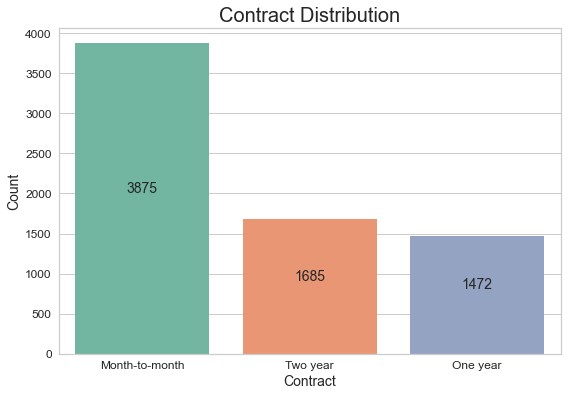

In [20]:
ax = sns.countplot(df['Contract'])

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)
    
plt.title('Contract Distribution', fontsize=20)
plt.xlabel('Contract', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()    

Basically, the term of the contract is a month, much less often clients draw it up for two years and even less often for a year

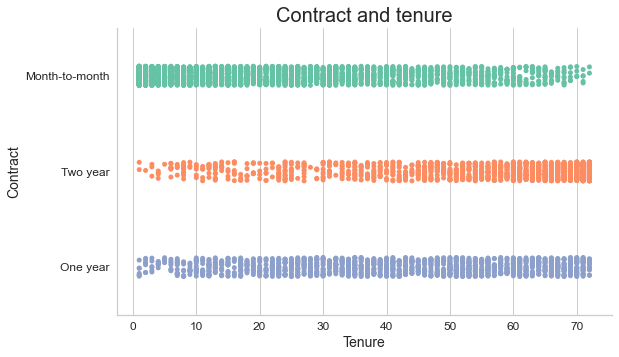

In [21]:
display(df.groupby('Contract')['TenureMonths'].describe().style.set_caption('Statistics of tenure by contract').\
        set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}]))

sns.catplot(y='Contract', x='TenureMonths', data=df, orient='h', height=4.7, aspect=1.8)

plt.title('Contract and tenure', fontsize=20)
plt.ylabel('Contract', fontsize=14)
plt.xlabel('Tenure', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()    

On the graph, the distribution of the number of months the customer has stayed with the company and the type of his contract. Most monthly contracts last 10-20 months, while two-year contracts tend to last around 60 months. Clients who enter into a longer contract are more loyal to the company and stay with it for a longer period of time

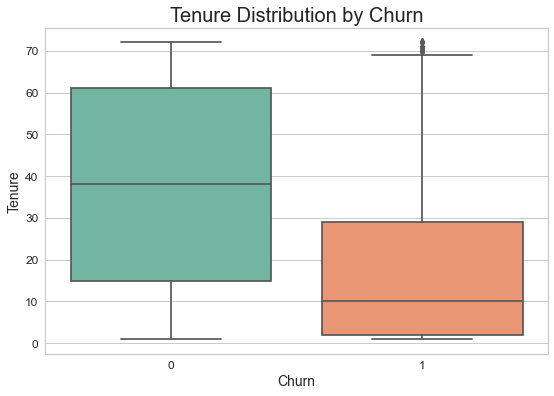

In [22]:
sns.boxplot(x='ChurnValue', y='TenureMonths', data=df)

plt.title('Tenure Distribution by Churn', fontsize=20)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Tenure', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()    

Indeed, the average number of months for clients who leave is significantly lower compared to those who stay. Most clients leave at the beginning of cooperation

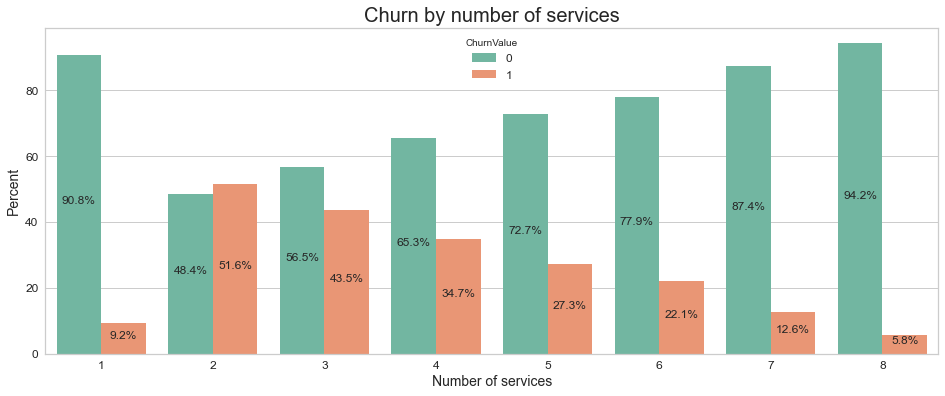

In [23]:
df_services = df[['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', \
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']]
df_services['PhoneService'] = np.where(df_services['PhoneService'] == 1, 'Yes', 'No')
df_services['InternetService'] = np.where(df_services['InternetService'] != 'No', 'Yes', 'No')

df_services['ChurnValue'] = df['ChurnValue']
df_services['num_services'] = (df_services == 'Yes').sum(axis=1)
churn_by_num_services = df_services.groupby('num_services')['ChurnValue'].value_counts(normalize=True)\
                                                            .mul(100).rename('percent').reset_index()

plt.figure(figsize=(16, 6))

ax = sns.barplot(x='num_services', y='percent', hue='ChurnValue', data=churn_by_num_services)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()/2 - 2), 
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=12)
    
plt.title('Churn by number of services', fontsize=20)
plt.xlabel('Number of services', fontsize=14)
plt.ylabel('Percent', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='ChurnValue', fontsize=12)

plt.show()

In the presence of one service (probably basic), most customers stay with the company. Clients who have two services are the most unpredictable: half can leave, half can continue cooperation. Starting with the number of services equal to three, the situation becomes constant: the more services, the lower the percentage of customer churn. Most likely, the number of services indicates the client's interest in the company, which positively correlates with monthly charges

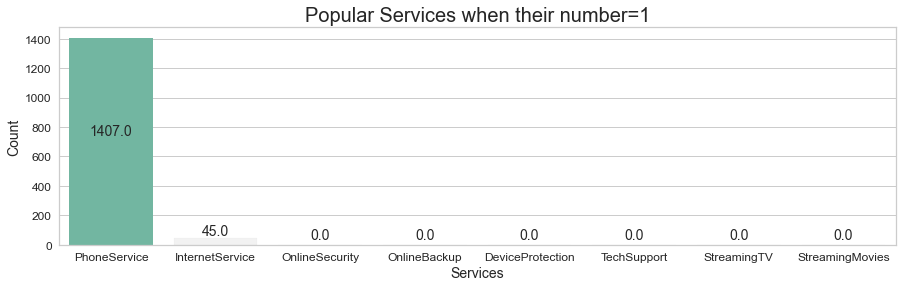

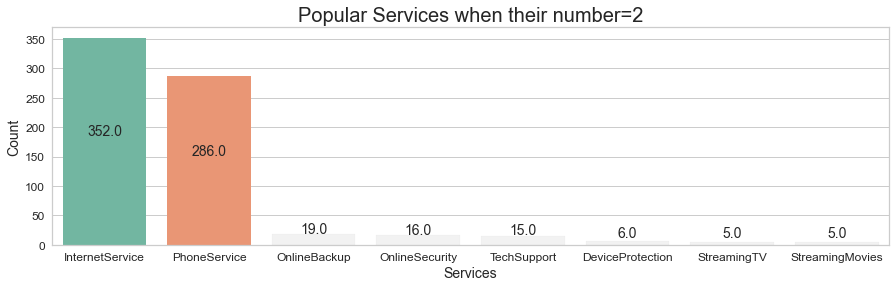

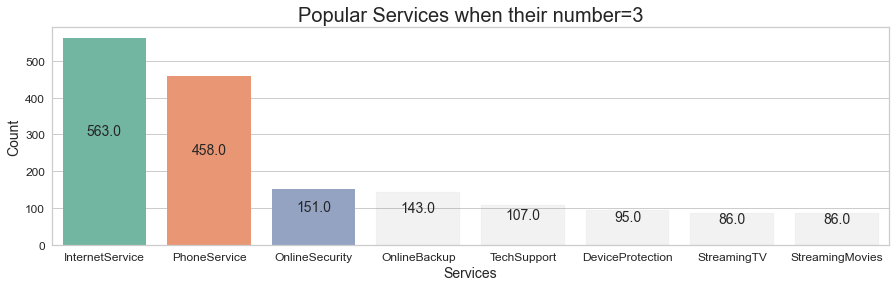

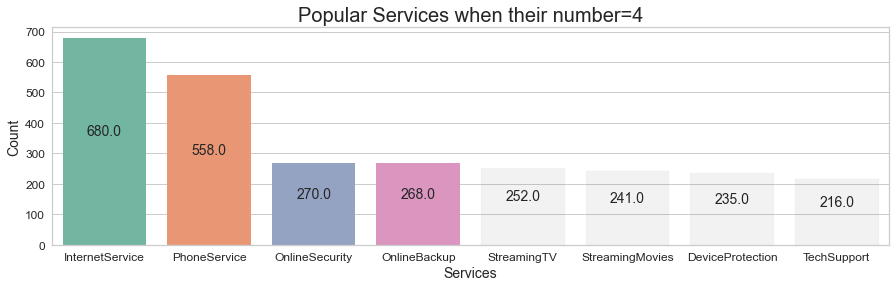

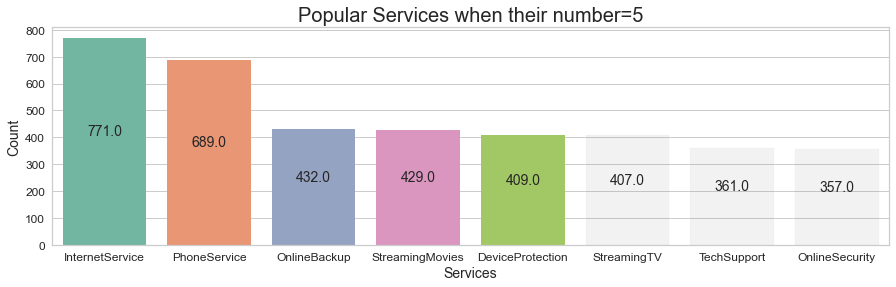

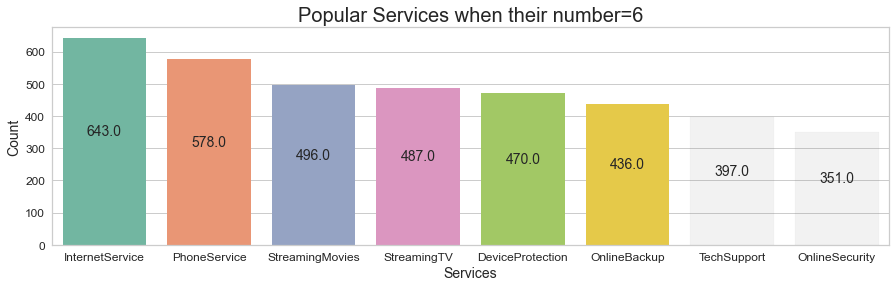

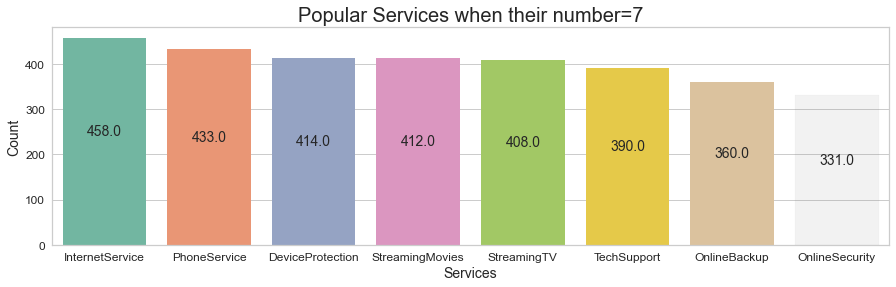

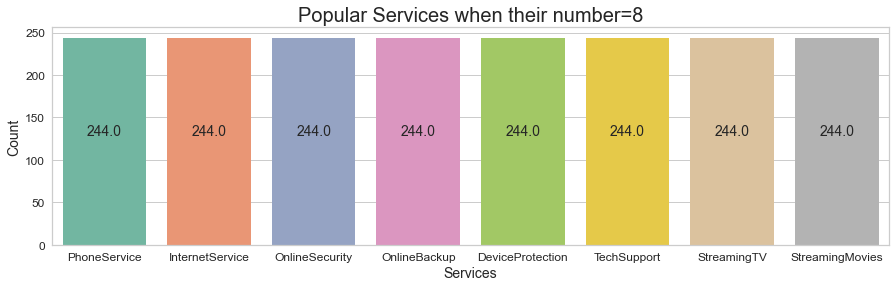

In [24]:
df_services_filt = df_services[df_services['ChurnValue'] == 0]
for num in set(df_services_filt['num_services']):
    df_popular_services = (df_services_filt[df_services_filt['num_services'] == num].iloc[:, :-2] == 'Yes')
    df_popular_services = df_popular_services.sum(axis=0).sort_values(ascending=False).reset_index()

    fig, axes = plt.subplots(figsize = (15, 4))
    ax = sns.barplot(x='index', y=0, data=df_popular_services, ax=axes)

    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                    ha='center',  
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',  
                    fontsize=14)
        if p.get_xy()[0] + 1 > num:
            p.set_color('grey')
            p.set_alpha(.1)

    plt.title(f'Popular Services when their number={num}', fontsize=20)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('Services', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()



Internet service and phone service are basic services. When choosing 3-5 services, services for security and backup are highlighted. Next in popularity are streaming services

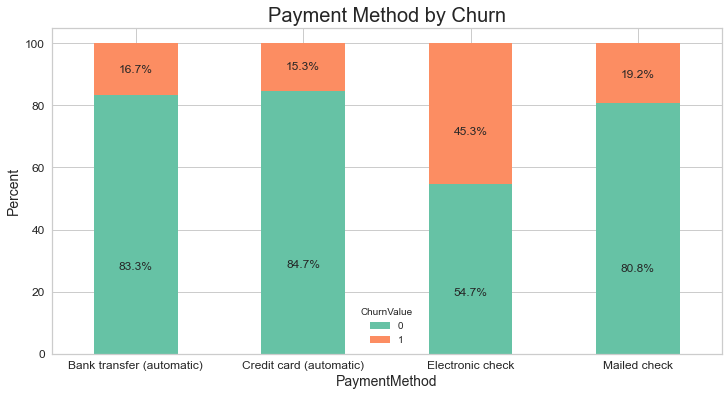

In [25]:
pay_method_by_churn = df.groupby(['PaymentMethod'])['ChurnValue'].value_counts(normalize=True).mul(100)\
                                                                        .rename('count').reset_index()
pay_method_by_churn = pd.pivot_table(pay_method_by_churn, values='count', columns=['ChurnValue'], \
                                     index=['PaymentMethod'])

ax = pay_method_by_churn.plot(kind='bar', width = 0.5, stacked = True, rot = 0, figsize=(12, 6))

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()*0.5, p.get_y() + 0.3*p.get_height()), 
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=12)
    
plt.title('Payment Method by Churn', fontsize=20)
plt.xlabel('PaymentMethod', fontsize=14)
plt.ylabel('Percent', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Payment methods such as Mailed check, Bank transfer and Credit card are equally good for customer retention. About 50% of customers with an electronic check leave the company

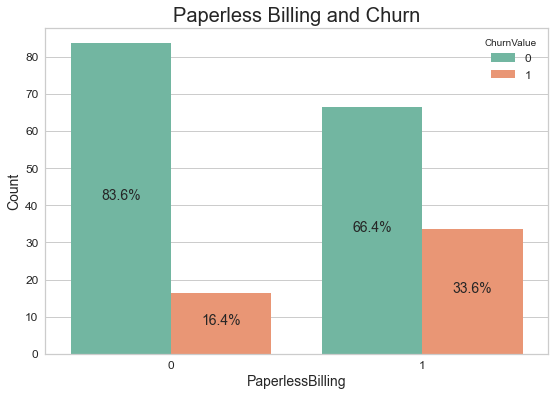

In [26]:
churn_by_paper_bill = df.groupby('PaperlessBilling')['ChurnValue'].value_counts(normalize=True).mul(100)\
                                                                        .rename('percent').reset_index()

ax = sns.barplot(x='PaperlessBilling', y='percent', hue='ChurnValue', data=churn_by_paper_bill)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()/2 - 2), 
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)
    
plt.title('Paperless Billing and Churn', fontsize=20)
plt.xlabel('PaperlessBilling', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title='ChurnValue', fontsize=12)

plt.show()

Among those customers who do not have paperless billing, the churn rate is lower

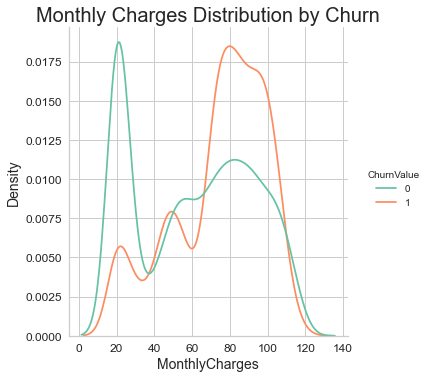

In [27]:
display(df.groupby('ChurnValue')['MonthlyCharges'].describe().reset_index().style\
        .set_caption('Statistics of monthly charges by churn')\
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}]))

sns.displot(x='MonthlyCharges', hue='ChurnValue', data=df, kind='kde', common_norm=False, palette='Set2')

plt.title('Monthly Charges Distribution by Churn', fontsize=20)
plt.xlabel('MonthlyCharges', fontsize=14)
plt.ylabel('Density', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show() 

In [28]:
# estimation of differences between two samples using the Mann-Whitney test
stat, p = mannwhitneyu(df[df['ChurnValue'] == 0]['MonthlyCharges'], df[df['ChurnValue'] == 1]['MonthlyCharges'], alternative='less')
print(f'p < 0.05: {p < 0.05}')

p < 0.05: True


Churn is higher for customers with high monthly payments

In [29]:
df[['MonthlyCharges', 'TotalCharges', 'TenureMonths']].corr()

MonthlyCharges  TotalCharges  TenureMonths
MonthlyCharges        1.000000      0.651065      0.246862
TotalCharges          0.651065      1.000000      0.825880
TenureMonths          0.246862      0.825880      1.000000

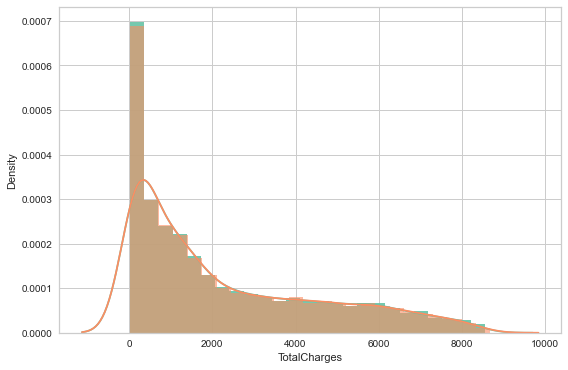

In [30]:
# high correlation says that probably the total сharges = spending per month * month, check it out
sns.distplot(df['MonthlyCharges'] * df['TenureMonths'], hist_kws = {'alpha': .9})
sns.distplot(df['TotalCharges'], hist_kws = {'alpha': .6})
plt.show() 

The graphs almost matched

In [31]:
# TotalCharges has no informational value
df.drop('TotalCharges', axis=1, inplace=True)

In [32]:
# check other features for correlation
df.corr().style.background_gradient(cmap='coolwarm')

## Survival Analysis

The easiest way to estimate the survival function is through the Kaplan-Meiser Estimator. It’s basically counting how many customers has churned/stayed at each time point. Kaplan-Meier Curves handles class imbalance automatically.

Nelson Aalen estimator estimates hazard rate. Thus, thanks to the survival analysis, it's possible to calculate the probability of customer churn at a certain time.

In [33]:
T = df['TenureMonths']  # represents durations
E = df['ChurnValue'] # represents censoring

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# event table summarizes survival data in terms of the number of events and the proportion surviving at each event time point
kmf.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0      7032     7032
1.0           613       380       233         0     7032
2.0           238       123       115         0     6419
3.0           200        94       106         0     6181
4.0           176        83        93         0     5981
...           ...       ...       ...       ...      ...
68.0          100         9        91         0      846
69.0           95         8        87         0      746
70.0          119        11       108         0      651
71.0          170         6       164         0      532
72.0          362         6       356         0      362

[73 rows x 5 columns]

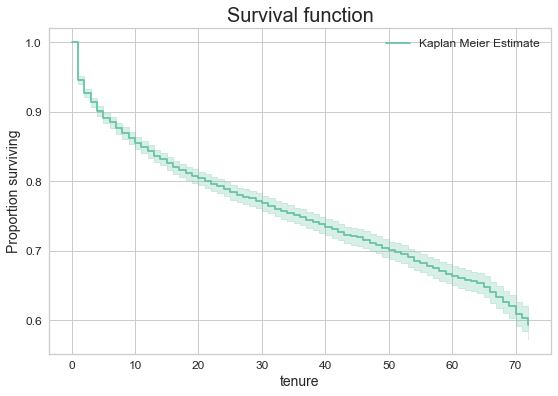

In [34]:
# visualization of the survival curve
kmf.plot_survival_function(label='Kaplan Meier Estimate')

plt.title('Survival function', fontsize=20)
plt.xlabel('tenure', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

In [35]:
# check the probability that a customer stays longer than one year
kmf.survival_function_at_times(12) * 100

12    84.319955
Name: KM_estimate, dtype: float64

The probability that a customer will stay with the company for 70 months (max observable) is about 60%. The probability that a customer stays longer than one year is about 85%

In [36]:
median = kmf.median_survival_time_
print(f'Median = {median}')

Median = inf


Unable to determine median

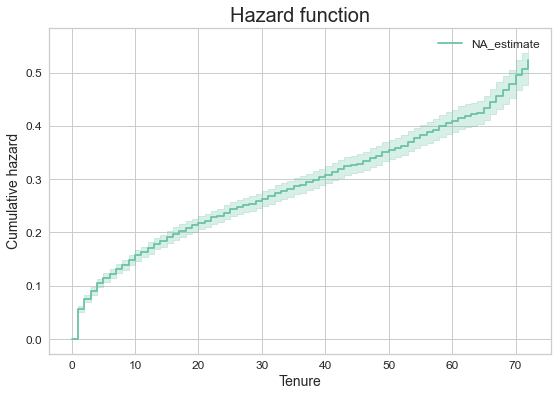

In [37]:
# the hazard function can be considered as giving the opposite side of the information given by the survivor function
naf = NelsonAalenFitter() 
naf.fit(T, event_observed=E)
naf.plot() 

plt.title('Hazard function', fontsize=20)
plt.xlabel('Tenure', fontsize=14)
plt.ylabel('Cumulative hazard', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

Survival analysis can be used as an exploratory tool to compare the differences in customer lifetime between cohorts

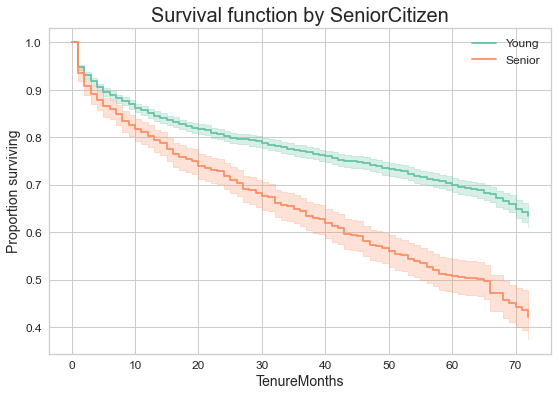

In [38]:
# by segmenting on the binary feature for senior versus young people, we get the following Kaplan-Meier curves
age_filt = (df['SeniorCitizen'] == 0)
kmf.fit(T[age_filt], event_observed=E[age_filt], label='Young')
kmf.plot_survival_function()

kmf.fit(T[~age_filt], event_observed=E[~age_filt], label='Senior')
kmf.plot_survival_function()

plt.title('Survival function by SeniorCitizen', fontsize=20)
plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()


Since the confidence interals also appear on the graph, we can see that the difference is statistically significant from tenure ≈ 10 months. Thus, within 10 months the probability of losing a client is approximately the same for clients of any age. After 10 months, a cohort of older clients is at greater risk

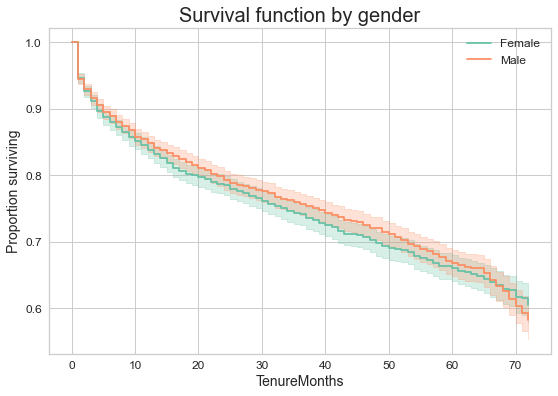

In [39]:
gender_filt = (df['Gender'] == 0)
kmf.fit(T[gender_filt], event_observed=E[gender_filt], label='Female')
kmf.plot_survival_function()

kmf.fit(T[~gender_filt], event_observed=E[~gender_filt], label='Male')
kmf.plot_survival_function()

plt.title('Survival function by gender', fontsize=20)
plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

Gender has no a clear difference Churn Rates between the values in categories. To verify this, let us check the hypothesis about the equality of the survival functions of two groups using the logrank test

In [40]:
# check if there is any significant difference between the groups being compared
results = logrank_test(T[gender_filt], T[~gender_filt], E[gender_filt], E[~gender_filt])
results.summary

test_statistic         p  -log2(p)
0        0.525707  0.468417  1.094134

A P value greater than (5% = 0.05) means that there is no significant difference between the groups we compared

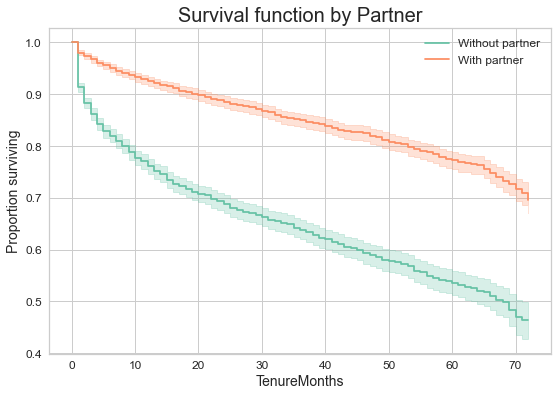

In [41]:
partner_filt = (df['Partner'] == 0)
kmf.fit(T[partner_filt], event_observed=E[partner_filt], label='Without partner')
kmf.plot_survival_function()

kmf.fit(T[~partner_filt], event_observed=E[~partner_filt], label='With partner')
kmf.plot_survival_function()

plt.title('Survival function by Partner', fontsize=20)
plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

The graph clearly shows that there is a difference in tenure between "with partner" and "without partner" customers. 1 in 4 customers have churned by month 15 of those who don't have a partner. By comparison, 1 in 4 customers churn by month 65 of those who have a partner, for a difference of 50 months (over 4 years of revenue)

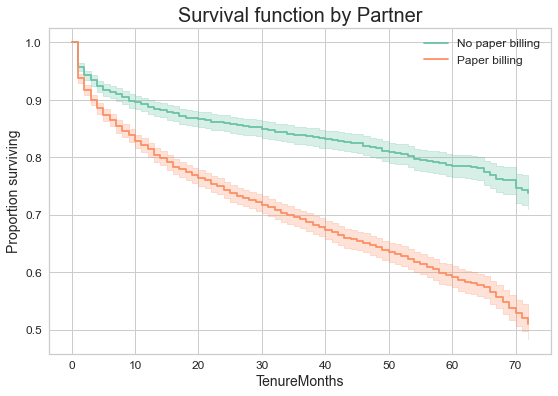

In [42]:
billing_filt = (df['PaperlessBilling'] == 0)
kmf.fit(T[billing_filt], event_observed=E[billing_filt], label='No paper billing')
kmf.plot_survival_function()

kmf.fit(T[~billing_filt], event_observed=E[~billing_filt], label='Paper billing')
kmf.plot_survival_function()

plt.title('Survival function by Partner', fontsize=20)
plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

Customers with paperless billing have highest probability to churn. Let's check this with logrank test

In [43]:
results = logrank_test(T[billing_filt], T[~billing_filt], E[billing_filt], E[~billing_filt])
results.summary

test_statistic             p    -log2(p)
0      189.511486  4.064094e-43  140.819974

The P-value gives us strong evidence that having a paperless billing was associated with churn. In our example, the absence of paperless billing has a major contribution to survival months

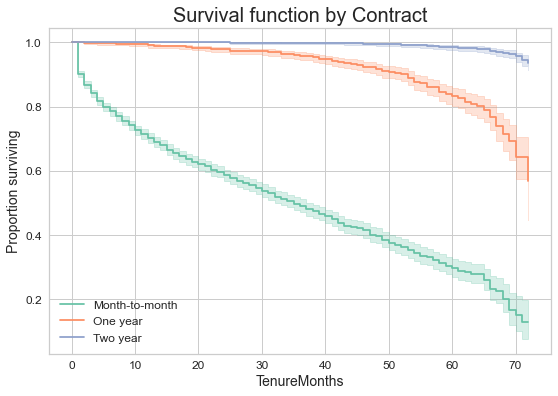

In [44]:
kmf.fit(T[df['Contract'] == 'Month-to-month'], event_observed=E[df['Contract'] == 'Month-to-month'],\
        label='Month-to-month')
kmf.plot_survival_function()

kmf.fit(T[df['Contract'] == 'One year'], event_observed=E[df['Contract'] == 'One year'], label='One year')
kmf.plot_survival_function()

kmf.fit(T[df['Contract'] == 'Two year'], event_observed=E[df['Contract'] == 'Two year'], label='Two year')
kmf.plot_survival_function()

plt.title('Survival function by Contract', fontsize=20)
plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()

Churn customers has lower values in one year and two year Contract. Customers with month-to-month contract have highest probability to churn

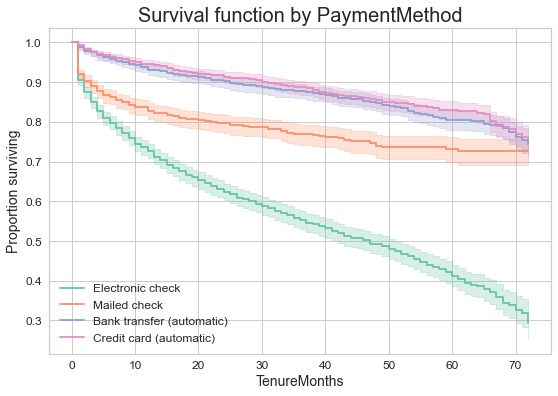

In [45]:
electro = (df['PaymentMethod']  == 'Electronic check')   
mail = (df['PaymentMethod']  == 'Mailed check')
bank = (df['PaymentMethod']  == 'Bank transfer (automatic)')
credit = (df['PaymentMethod']  == 'Credit card (automatic)')


kmf.fit(T[electro], event_observed=E[electro], label='Electronic check')
kmf.plot_survival_function()

kmf.fit(T[mail], event_observed=E[mail], label='Mailed check')
kmf.plot_survival_function()

kmf.fit(T[bank], event_observed=E[bank], label='Bank transfer (automatic)')
kmf.plot_survival_function()

kmf.fit(T[credit], event_observed=E[credit], label='Credit card (automatic)')
kmf.plot_survival_function()

plt.title('Survival function by PaymentMethod', fontsize=20)
plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()


Customers with electronic check tend to churn more quickly. Survival functions for customers with a credit card and bank transfer are no different

With Kaplan-Meier, Nelson-Aalen, and Log-Rank Test we were only able to consider one variable at a time. And one more thing to notice here is that we were performing operations only on categorical variables like gender, contact, etc., which are not generally used for non-categorical data like monthly charges. As a solution, we use the Cox proportional hazards regression analysis, which works for both quantitative predictor (non-categorical) variables and categorical variables

In [46]:
# handling categorical data
df_cox = pd.get_dummies(df.drop(['CustomerID', 'CLTV'], axis=1), drop_first=True)

# elimination of high correlation
df_cox = df_cox.drop(df_cox.filter(regex=('No.*service')), axis=1)

# computes p-values using the chi-squared test (95% confidence interval)
cph = CoxPHFitter(alpha=0.05) 

cph.fit(df_cox, 'TenureMonths', event_col='ChurnValue') 

# p-value<0.05 means the column is statistically significant and safe to include
df_cox_sum = cph.summary.reset_index().query('p < 0.05') 

# the values exp(coef) is called the hazard ratio (HR)
# the HR greater than 1 indicates that as the value of ith covariate increases
# the event hazard increases, and thus the duration of survival decreases
display(df_cox_sum[df_cox_sum['exp(coef)'] > 1].style.set_caption('Covariates with high hazard rate')\
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}]))
print('\n')
display(df_cox_sum[df_cox_sum['exp(coef)'] < 1].style.set_caption('Covariates with low hazard rate')\
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}]))

Paperless billing increases the risk of customer churn.
CityTargetEnc also increases the risk of customer churn, as expected.
Payment methods have an exp(coef) of about 2. This means that the customer's hazard ratio increases by almost 2 times when they choose certain payment method.

The exp(coef) of customer with partner is 0.65, which means that for at any given time, subjects in a relationship are 0.65 times less likely to churn than single subjects. 
Also, the presence of dependents reduces the risk of customer churn. 
Services such as MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport also affect churn risk.
Long-term contracts (one year and two years) are associated with a reduced risk of churn.
exp(coef) of SeniorCitizen is close to zero, probably results are not significant.

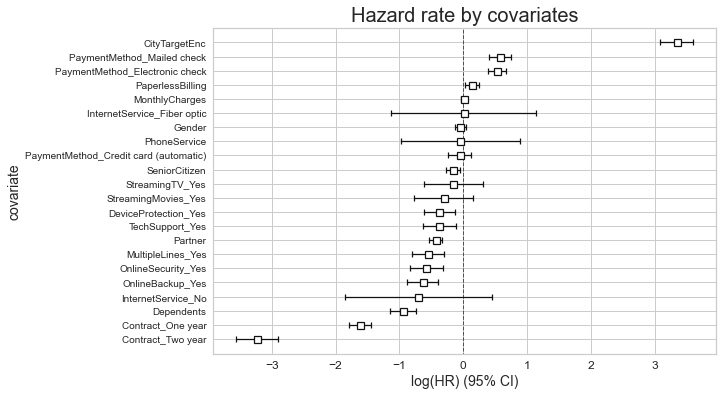

In [47]:
# check which factor affects the most from the graph
cph.plot()

plt.title('Hazard rate by covariates', fontsize=20)
plt.xlabel('log(HR) (95% CI)', fontsize=14)
plt.ylabel('covariate', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

plt.show()

Contract and PaymentMethod have significant differences. Covariates near zero have no effect on churn. Whiskers of SeniorCitizen boxplot is close to 0, so we will not take into account

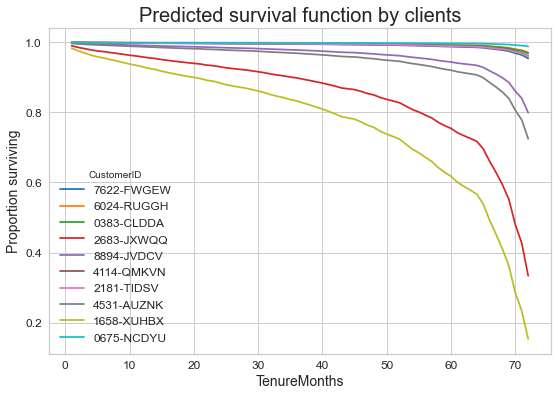

In [48]:
# selection of the top 10 important buyers in terms of CLTV
vip_customers = df['CLTV'].sort_values(ascending=False)[:10].index
slice_by_clients = df_cox.iloc[vip_customers, ~df_cox.columns.isin(['TenureMonths', 'ChurnValue'])]

# the survival probability for selected customers
cph.predict_survival_function(slice_by_clients).plot(colormap='tab10')

plt.title('Predicted survival function by clients', fontsize=20)

plt.xlabel('TenureMonths', fontsize=14)
plt.ylabel('Proportion surviving', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(df.iloc[vip_customers]['CustomerID'].to_list(), title='CustomerID',  fontsize=12)

plt.show()

The most dangerous customer in terms of risk is the client with ID 1658-XUHBX. By 65 months, his risk of churn is 50%. For the client with ID 2683-JXWQQ, this risk by the same time is 70%. For clients 4531-AUZNK and 8894-JVDCV, there is a small risk of churn during the period under review. Other clients are not considered dangerous (the risk of churn is minimal).

Creating survival curves at each client level helps to develop an individual strategy for high-value clients in advance сonsidering different survival risk on the timeline

## Preprocessing

In [49]:
df.drop(['CustomerID', 'CLTV'], axis=1, inplace=True)

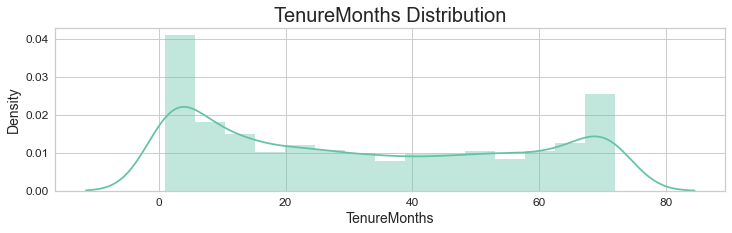

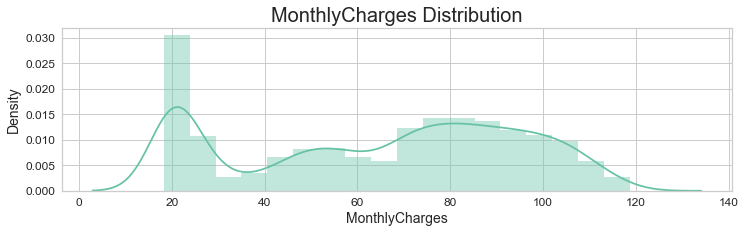

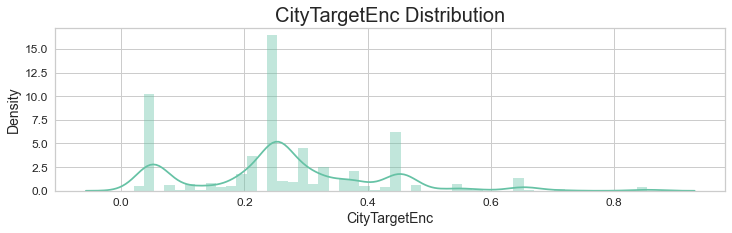

In [50]:
# checking distributions of numerical data
num_cols = ['TenureMonths', 'MonthlyCharges', 'CityTargetEnc']

for col in num_cols:
    fig, axes = plt.subplots(figsize = (12, 3))
    ax = sns.distplot(df[col], ax=axes)

    plt.title(f'{col} Distribution', fontsize=20)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Density', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

The graphs of the distribution of numerical variables indicate a non-normal distribution, it is necessary to transform

In [51]:
# checking for constants, missing values and the number of unique categories
cat_cols = df.select_dtypes(include='object').columns.tolist()

df[cat_cols].describe()

MultipleLines InternetService OnlineSecurity OnlineBackup  \
count           7032            7032           7032         7032   
unique             3               3              3            3   
top               No     Fiber optic             No           No   
freq            3385            3096           3497         3087   

       DeviceProtection TechSupport StreamingTV StreamingMovies  \
count              7032        7032        7032            7032   
unique                3           3           3               3   
top                  No          No          No              No   
freq               3094        3472        2809            2781   

              Contract     PaymentMethod  
count             7032              7032  
unique               3                 4  
top     Month-to-month  Electronic check  
freq              3875              2365

In [52]:
# split dataframe into train and test subsets
X = df.drop('ChurnValue', axis=1)
y = df['ChurnValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

In [53]:
# applying the Box-Cox transformation and standardization to numerical data
num_pipeline = Pipeline(steps=[('p', PowerTransformer(method='box-cox')),
                               ('s', StandardScaler())])
# One-Hot Encoding for categorical data
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

full_processor = ColumnTransformer(transformers=[('num_features', num_pipeline, num_cols),
                                                 ('cat_features', cat_pipeline, cat_cols)])

X_train = pd.DataFrame(full_processor.fit_transform(X_train),
                       columns=[i.split('__')[1] for i in full_processor.get_feature_names_out()])
X_test = pd.DataFrame(full_processor.transform(X_test),
                      columns=[i.split('__')[1] for i in full_processor.get_feature_names_out()])


## Modeling

When evaluating models, it must be taken into account that the target variable is unbalanced. In our case, to evaluate the model, it is better to focus on the recall metric, since the business needs to identify as many churning customers as possible

### Logistic Regression

In [54]:
# baseline
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_score = lr.predict_proba(X_test)[:, 1]

In [55]:
# creating a dataframe for comparing metrics of different models
model_metrics = pd.DataFrame(index=['accuracy', 'roc-auc', 'precision', 'recall', 'f1'], 
                       data = {'LogReg': [accuracy_score(y_test, lr_pred),
                                               roc_auc_score(y_test, lr_score), 
                                               precision_score(y_test, lr_pred),
                                               recall_score(y_test, lr_pred),
                                               f1_score(y_test, lr_pred)]})

model_metrics

LogReg
accuracy   0.847910
roc-auc    0.905109
precision  0.775432
recall     0.631250
f1         0.695952

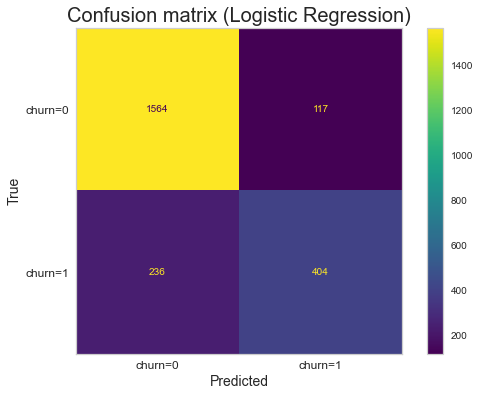

In [56]:
# confusion matrix
plot_confusion_matrix(lr, X_test, y_test, display_labels=['churn=0','churn=1'])

plt.title('Confusion matrix (Logistic Regression)', fontsize=20)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)

plt.show()

Logistic regression with default parameters gives low recall, which is undesirable in our case. Only 63% of the churned customers were able to recognize the algorithm

## SMV

In [57]:
# split into 3 folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [58]:
params = {'C': [0.1, 1],
          'gamma': [1, 0.01, 0.001],
          'kernel': ['rbf', 'poly', 'sigmoid']}

# automatic adjustment of for weights imbalanced classes
svc_model = SVC(class_weight='balanced', random_state=RANDOM_SEED)

# search over parameter values for an estimator using GridSearch
svc = GridSearchCV(svc_model, params, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1)
svc.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced', random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'gamma': [1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='roc_auc', verbose=1)

In [59]:
# model with the best parameters
svc_model = SVC(**svc.best_params_, class_weight='balanced', probability=True, random_state=RANDOM_SEED)
svc_model.fit(X_train, y_train)

svc_pred = svc_model.predict(X_test)
svc_score = svc_model.predict_proba(X_test)[:, 1]

In [60]:
model_metrics['SVM'] = [accuracy_score(y_test, svc_pred), roc_auc_score(y_test, svc_score), 
                            precision_score(y_test, svc_pred), recall_score(y_test, svc_pred), 
                            f1_score(y_test, svc_pred)]
model_metrics

LogReg       SVM
accuracy   0.847910  0.800948
roc-auc    0.905109  0.905619
precision  0.775432  0.596950
recall     0.631250  0.856250
f1         0.695952  0.703466

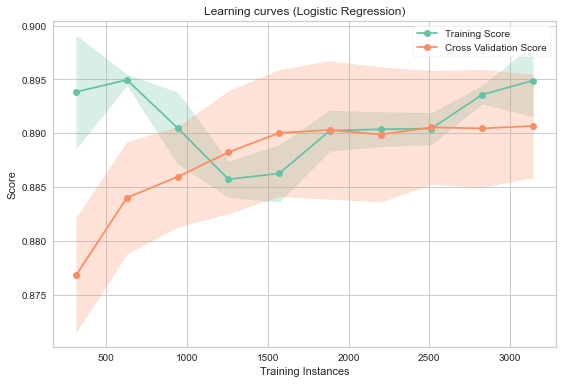

<AxesSubplot:title={'center':'Learning curves (Logistic Regression)'}, xlabel='Training Instances', ylabel='Score'>

In [61]:
# diagnosing if the model is overfitting or underfitting using learning curves 
visualizer = LearningCurve(svc_model, cv=cv, scoring='roc_auc',
                           train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1,
                           verbose=1, title='Learning curves (Logistic Regression)')

visualizer.fit(X_train, y_train)

visualizer.show() 

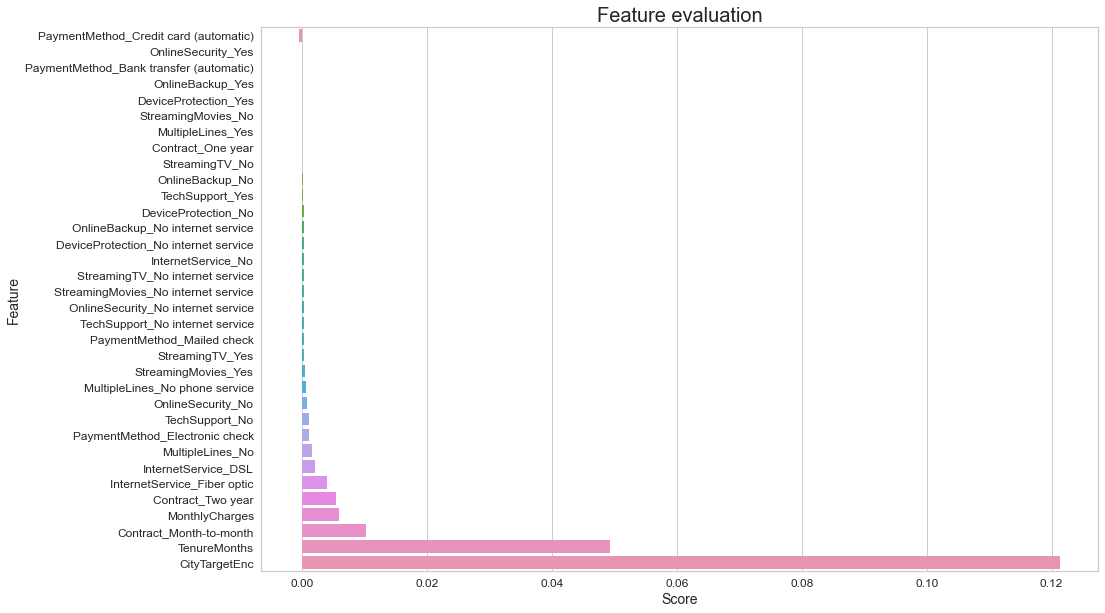

In [62]:
# feature evaluation using permutation
perm_importance = permutation_importance(svc_model, X_test, y_test, scoring='roc_auc')
sorted_idx = perm_importance.importances_mean.argsort()
feature_names = svc_model.feature_names_in_

plt.figure(figsize=(15, 10))

sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=feature_names[sorted_idx], orient='h')

plt.title('Feature evaluation', fontsize=20)

plt.xlabel('Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Random Forest

In [63]:
# params to prevent overfitting
params = {'max_depth': [7, 10],
          'n_estimators': [500, 1000],
          'max_features': ['log2', 'sqrt'], 
          'min_samples_leaf': [20, 40], 
          'criterion': ['gini', 'entropy'],
          'max_leaf_nodes': [15, 18]}

rf_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED)

rf = GridSearchCV(rf_model, params, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)
rf.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [7, 10],
                         'max_features': ['log2', 'sqrt'],
                         'max_leaf_nodes': [15, 18],
                         'min_samples_leaf': [20, 40],
                         'n_estimators': [500, 1000]},
             scoring='roc_auc', verbose=1)

In [64]:
rf_model = RandomForestClassifier(**rf.best_params_, class_weight='balanced', random_state=RANDOM_SEED)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_score = rf_model.predict_proba(X_test)[:, 1]

In [65]:
model_metrics['RandomForest'] = [accuracy_score(y_test, rf_pred), roc_auc_score(y_test, rf_score),
                                 precision_score(y_test, rf_pred), recall_score(y_test, rf_pred), 
                                 f1_score(y_test, rf_pred)]
model_metrics

LogReg       SVM  RandomForest
accuracy   0.847910  0.800948      0.794054
roc-auc    0.905109  0.905619      0.890318
precision  0.775432  0.596950      0.589404
recall     0.631250  0.856250      0.834375
f1         0.695952  0.703466      0.690815

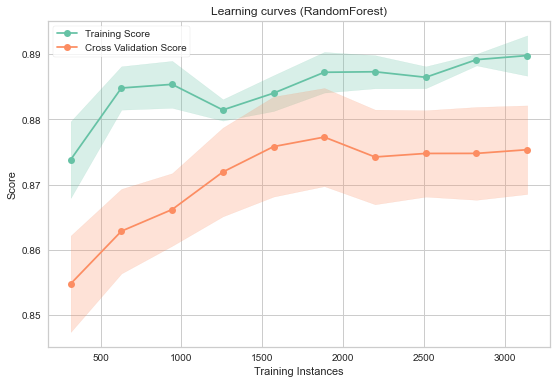

<AxesSubplot:title={'center':'Learning curves (RandomForest)'}, xlabel='Training Instances', ylabel='Score'>

In [66]:
visualizer = LearningCurve(rf_model, cv=cv, scoring='roc_auc',
                           train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1,
                           verbose=1, title='Learning curves (RandomForest)')

visualizer.fit(X_train, y_train)

visualizer.show() 

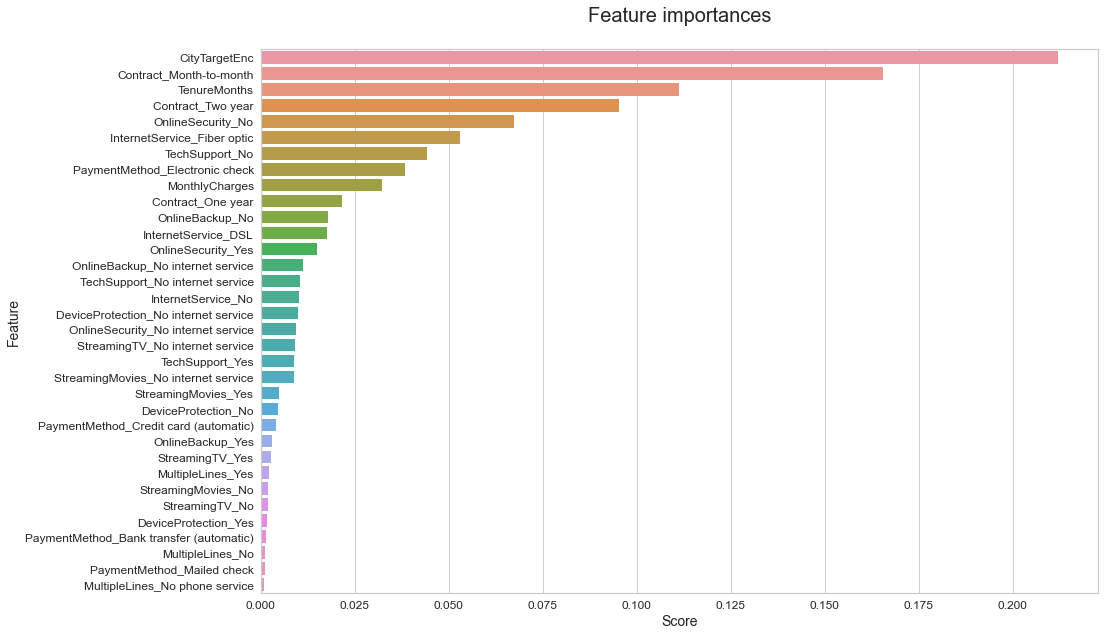

In [67]:
# feature importances
rf_feat = pd.DataFrame({'Feature': list(X_train), 'Value': rf_model.feature_importances_})
rf_feat = rf_feat.sort_values(by='Value', ascending=False)

plt.figure(figsize=(15, 10))

sns.barplot(data=rf_feat, x='Value', y='Feature').set(title='Important features to predict customer Churn')

plt.title('Feature importances\n', fontsize=20)

plt.xlabel('Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### XGBoost

In [68]:
params = {'n_estimators': [300, 500],
          'subsample': [0.2, 0.6],
          'max_depth': [3, 5],
          'learning_rate': [0.01, 0.1],
          'lambda': [0.3, 0.5],
          'alpha': [0.3, 0.5]}

# set scale_pos_weight for imbalanced classes
xgb_model = XGBClassifier(scale_pos_weight=2, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)

xgb = GridSearchCV(xgb_model, params, scoring='roc_auc', cv=cv, verbose=1, n_jobs=-1)
xgb.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=Non...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=2,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'alpha': [0.3, 0.5], 'lambda': [0.3, 0.5],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [300, 500], 'subsample': [0.2, 0.6]},
             scoring='roc_auc', verbose=1)

In [69]:
xgb_model = XGBClassifier(**xgb.best_params_, scale_pos_weight=2, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_score = xgb_model.predict_proba(X_test)[:, 1]

In [70]:
model_metrics['XGBoost'] = [accuracy_score(y_test, xgb_pred), roc_auc_score(y_test, xgb_score), 
                            precision_score(y_test, xgb_pred), recall_score(y_test, xgb_pred),
                            f1_score(y_test, xgb_pred)]
model_metrics

LogReg       SVM  RandomForest   XGBoost
accuracy   0.847910  0.800948      0.794054  0.819905
roc-auc    0.905109  0.905619      0.890318  0.908822
precision  0.775432  0.596950      0.589404  0.635036
recall     0.631250  0.856250      0.834375  0.815625
f1         0.695952  0.703466      0.690815  0.714090

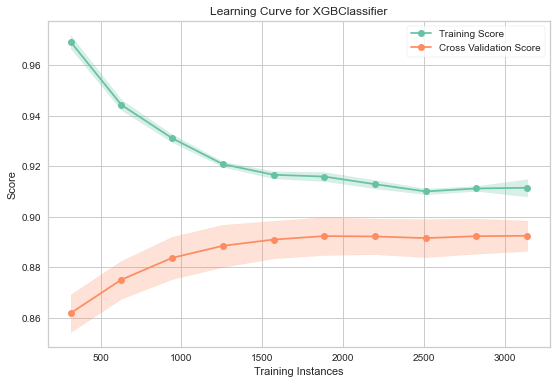

<AxesSubplot:title={'center':'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [71]:
visualizer = LearningCurve(xgb_model, cv=cv, eval_metric = 'logloss', scoring='roc_auc',
                           train_sizes=np.arange(0.1, 1.1, 0.1), n_jobs=-1,
                           verbose=1, tile='Learning curves (XGBoost)')

visualizer.fit(X_train, y_train)

visualizer.show() 

### Catboost

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

# for catboost ignoring categorical data preprocessing
X_train[num_cols] = num_pipeline.fit_transform(X_train[num_cols])
X_test[num_cols] = num_pipeline.transform(X_test[num_cols])


params = {'n_estimators': [100, 300, 500],
          'max_depth': [3, 5, 7],
          'learning_rate': [0.01, 0.1, 0.2], 
          'l2_leaf_reg': [5, 7, 9]}

catb_model = CatBoostClassifier(scale_pos_weight=3, logging_level='Silent',
                                allow_writing_files=False, random_state=RANDOM_SEED)
catb = GridSearchCV(catb_model, params, scoring='roc_auc', cv=cv, n_jobs=-1)

catb.fit(X_train, y_train, cat_features=[X_train.columns.get_loc(i) for i in cat_cols], eval_set=(X_test, y_test))

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb3e21c7dc0>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [5, 7, 9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc')

In [73]:
catb_model = CatBoostClassifier(**catb.best_params_, scale_pos_weight=3, logging_level='Silent',
                                 allow_writing_files=False, random_state=RANDOM_SEED)

# enabling a learning curve created by CatBoost
catb_model.fit(X_train, y_train, cat_features=[X_train.columns.get_loc(i) for i in cat_cols],
         eval_set=(X_test, y_test), verbose=False, plot=True)

catb_pred = catb_model.predict(X_test)
catb_score = catb_model.predict_proba(X_test)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [74]:
model_metrics['CatBoost'] = [accuracy_score(y_test, catb_pred), roc_auc_score(y_test, catb_score), 
                             precision_score(y_test, catb_pred), recall_score(y_test, catb_pred), 
                             f1_score(y_test, catb_pred)]
model_metrics

LogReg       SVM  RandomForest   XGBoost  CatBoost
accuracy   0.847910  0.800948      0.794054  0.819905  0.813442
roc-auc    0.905109  0.905619      0.890318  0.908822  0.918935
precision  0.775432  0.596950      0.589404  0.635036  0.612134
recall     0.631250  0.856250      0.834375  0.815625  0.882812
f1         0.695952  0.703466      0.690815  0.714090  0.722969

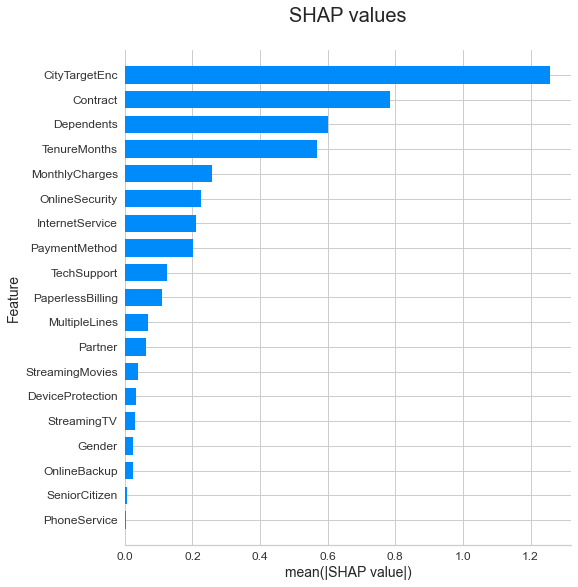

In [75]:
# feature importances using SHAP values
explainer = shap.TreeExplainer(catb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

plt.title('SHAP values\n', fontsize=20)
plt.xlabel('mean(|SHAP value|)', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

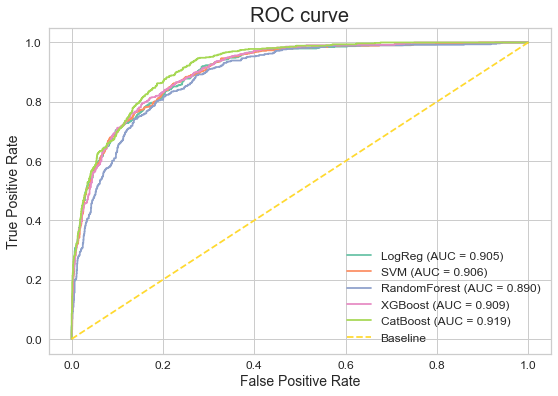

In [76]:
# comparison of ROC-curves
fpr, tpr, thresholds = roc_curve(y_test, lr_score)
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc_score(y_test, lr_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, svc_score)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_score(y_test, svc_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, rf_score)
plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc_score(y_test, rf_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, xgb_score)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_score):.3f})')

fpr, tpr, thresholds = roc_curve(y_test, catb_score)
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc_score(y_test, catb_score):.3f})')

plt.plot([0, 1], label='Baseline', linestyle='--')

plt.title('ROC curve', fontsize=20)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower right', fontsize=12)

plt.show()

Optimal threshold value is: 0.5510598952731557


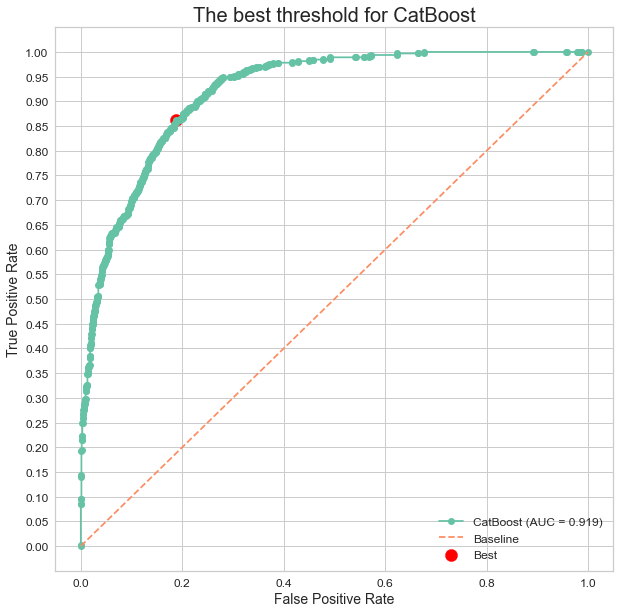

Accuracy score before and after thresholding: 0.8134424816889272, 0.8263679448513572
Precision score before and after thresholding: 0.6121343445287107, 0.6366782006920415
Recall score before and after thresholding: 0.8828125, 0.8625
F1 score before and after thresholding: 0.7229686500319898, 0.7325812873258128


In [77]:
# finding the optimal threshold using ROC curve
plt.figure(figsize=(10, 10))

fpr, tpr, thresholds = roc_curve(y_test, catb_score) 
plt.plot(fpr, tpr, marker='o', label=f'CatBoost (AUC = {roc_auc_score(y_test, catb_score):.3f})')

plt.plot([0, 1], label='Baseline', linestyle='--')

# the threshold closest to the top-left of the plot
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print(f'Optimal threshold value is: {optimal_threshold}')
# display on the ROC curve of the best threshold
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], marker='o', color='red', s=150, label='Best')

# class labels by the new threshold
opt_pred = [1 if i >= optimal_threshold else 0 for i in catb_score]

plt.title('The best threshold for CatBoost', fontsize=20)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(np.arange(0, 1.05, 0.05), fontsize=12)

plt.legend(loc='lower right', fontsize=12)

plt.show()

print(f'Accuracy score before and after thresholding: {accuracy_score(y_test, catb_pred)}, {accuracy_score(y_test, opt_pred)}')
print(f'Precision score before and after thresholding: {precision_score(y_test, catb_pred)}, {precision_score(y_test, opt_pred)}')
print(f'Recall score before and after thresholding: {recall_score(y_test, catb_pred)}, {recall_score(y_test, opt_pred)}')
print(f'F1 score before and after thresholding: {f1_score(y_test, catb_pred)}, {f1_score(y_test, opt_pred)}')

In [78]:
pickle.dump((catb_model, cbe_encoder, num_pipeline, optimal_threshold), open('model.pkl', 'wb'))

## Conclusion

Class weights have been added for each algorithm to handle imbalanced classes and reach a recall>80%. Also each model was tuned to avoid overfitting.
Tree-like algorithms like Random Forest and XGBoost are slightly overfitted. Catboost and SVM models doesn't suffer from overfitting. In terms of metrics, Catboost is the best model. 
The threshold used to map probabilities to class labels has been adjusted for Catboost. Threshold-Moving contributed to a slight improvement metrics (by reducing recall).
The most important features for churn prediction are City, Contract, TenureMonths, InternetService, PaymentMethod, OnlineSecurity, TechSupport, PaperlessBilling. 